In [1]:
# show the matplotlib plotted graph within notebook lines.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### In case that your tqdm is not installed. Please go to the Start(Windows)->Anaconda2(64-bit)->Anaconda Prompt(py35)

### type: conda install tqdm -y

In [2]:
# import required libraries
# pandas:Data framework library for Python
# sklearn: Library to perform machine learning tasks
import os
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
# import scipy.stats as st
import re
import codecs
from collections import Counter
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import sklearn 
import sklearn.datasets
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import mutual_info_classif
from scipy import stats

C:\Anaconda\envs\py35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# nltk.download('stopwords')

In [4]:
# extract data
# !gzip -d -k 20news-19997.tar.gz
# !tar -xf 20news-19997.tar

In [5]:
# display newsgroups directories
# !ls 20_newsgroups

## Support functions

In [6]:
def getFilesDirectory(datapath='20_newsgroups'):
    # create file directory for all files
    files = []
    for (path, dirnames, filenames) in os.walk(datapath):
        files.extend(os.path.join(path, name) for name in filenames)
    # putting file directories into pandas dataframe
    directorydf = pd.DataFrame(files)
    directorydf.columns = ['Directories']
    return directorydf

In [7]:
directorydf = getFilesDirectory()
directorydf.head(n=5)

,Directories
0,20_newsgroups\alt.atheism\49960
1,20_newsgroups\alt.atheism\51060
2,20_newsgroups\alt.atheism\51119
3,20_newsgroups\alt.atheism\51120
4,20_newsgroups\alt.atheism\51121


In [8]:
# create function to help encoding the targets
def label_target(d):
    if d.find("alt.atheism") > 0:
      return 0
    if d.find("comp.graphics") > 0:
      return 1
    if d.find("comp.os.ms-windows.misc") > 0:
      return 2
    if d.find("comp.sys.ibm.pc.hardware") > 0:
      return 3
    if d.find("comp.sys.mac.hardware") > 0:
      return 4
    if d.find("comp.windows.x") > 0:
      return 5
    if d.find("misc.forsale") > 0:
      return 6
    if d.find("rec.autos") > 0:
      return 7
    if d.find("rec.motorcycles") > 0:
      return 8
    if d.find("rec.sport.baseball") > 0:
      return 9
    if d.find("rec.sport.hockey") > 0:
      return 10
    if d.find("sci.crypt") > 0:
      return 11
    if d.find("sci.electronics") > 0:
      return 12
    if d.find("sci.med") > 0:
      return 13
    if d.find("sci.space") > 0:
      return 14
    if d.find("soc.religion.christian") > 0:
      return 15
    if d.find("talk.politics.guns") > 0:
      return 16
    if d.find("talk.politics.mideast") > 0:
      return 17
    if d.find("talk.politics.misc") > 0:
      return 18
    if d.find("talk.religion.misc") > 0:
      return 19
    return 'Other'

## Q1

### (a)

i) For features preparation, we use a binary term frequency-based unigram model to encode the text documents. I think the unigram term frequency encoding method is a reasonable first step to start with, which is straightforward to implement. The binary encoding method allows the features to be normalized to the same scale (0 or 1), which is highly desirable for some classifier, such as SVM and NB.

In the preprocessing part, we firstly use lowercase unification to avoid case-sensitivity. Secondly, the stop words are removed in the text. It is observed there are plenty of 2-letter word tokens that does not make much sense, possibly due to the lowercase of acronyms, which are removed as well. Finaly, a lemmatizer is applied in order to merge the similar words together.

ii) Feature ranking is based on the frequency of all the words updated from the entire document collection, the higher term frequency of a word, the higher ranking, which suggests potentially higher relevance in the context.

iii) The number of features selected directly affects the performance of a classification. Here it should be sufficiently large for the model in order to capture the essence, and computional-wise less expensive. Here, we use the top 400 words for the features.

### (b)

In [9]:
def dataPreprocessor(k, fs, encode, directorydf, size=None):
    """
    INPUT
        k: int. number of features to use
        fs: string. From ['tf', 'mi']
        encode: string. From ['tf', 'boolean']
        drectorydf: Dataframe. It is given, see above support functions
        size: int. Sample size. Default should be the data size.
    OUTPUT
        data: Dataframe. preprocessed data
    
    ps: 'tf' means term frequency, 'mi' means mutual information
    """
    
    ########### your code goes here ###########
    
    # Sizing data
    total_directory = directorydf[:size] if size else directorydf
    N = len(total_directory)
    
    stop_words = set(stopwords.words('english'))
    months = set(['jan', 'january', 'feb', 'february', 'mar', 'apr', 'april', 'may', 'jun', 'june', 'jul', 'july', 
                  'aug', 'august', 'sep', 'september', 'oct', 'october', 'nov', 'november', 'dec', 'december'])
    wln = WordNetLemmatizer()
    counter = Counter()
    
    for rownum, row in enumerate(directorydf.itertuples()):
        with codecs.open(row.Directories, 'r', encoding='utf-8', errors='ignore') as myfile:
            # Remove numbers in the documents
            tmp_text = re.sub('\d+', '', myfile.read().lower())

            # Use lemmatizer, stop-words filter and ignoring a length of word less than 2
            counter.update([wln.lemmatize(word) for word in re.findall(r'\w+', tmp_text)
                            if (word not in stop_words) and (word not in months) and (len(word) > 2)])
        if (rownum % 5000 == 0):
            print("processed %d files" % (rownum + 1))
            
    print("Initial Counter update complete...\n")
            
    docs = N * [None]
    if fs == 'tf':
        topk = counter.most_common(k)
    elif fs == 'mi':
        topk = counter.most_common(2000)
        targets = N * [None]
        labels = N * [None]
    
    # now we had top k words, count the termn frequecy or binary of these words in individual file
    for rownum, row in enumerate(total_directory.itertuples()):
        with codecs.open(row.Directories, 'r' ,encoding='utf-8', errors='ignore') as myfile:
            tmp_text = re.sub('\d+', '', myfile.read().lower())

            tmp_counter = Counter([wln.lemmatize(word) for word in re.findall(r'\w+', tmp_text)])
            if encode == 'tf':
                topk_doc = [tmp_counter[word] for (word, word_count) in topk]
            # if the word appears in the doc, then 1, else 
            elif encode == 'boolean':
                topk_doc = [1 if tmp_counter[word] else 0 for (word, word_count) in topk]
            
            doc_label = row.Directories
            doc_target = label_target(doc_label)
            if fs == 'mi':
                docs[rownum] = topk_doc
                targets[rownum] = doc_target
                labels[rownum] = doc_label
            elif fs == 'tf':
                docs[rownum] = topk_doc + [doc_target] + [doc_label]
            
            if (rownum % 5000 == 0):
                print("processed %d files" % (rownum + 1))
                
    print("Encoding complete...\n")
    
    if fs == 'mi':
        a_docs = np.asarray(docs)

        print("Calculating mutual information...")
        mi = mutual_info_classif(a_docs, targets)
        print("MI complete...")
        
        sort_mi_idx = np.argsort(mi)
        topk_mi_idx = sort_mi_idx[:k]
#         print(topk_mi_idx)
        
        topk_mi_docs = a_docs[:, topk_mi_idx]
#         print(topk_mi_docs.shape)
        
        topk = [topk[i] for i in topk_mi_idx]
        data = pd.DataFrame(topk_mi_docs, columns=[c[0] for c in topk])
        data['target'] = targets
        data['label'] = labels
    elif fs == 'tf':
        data = pd.DataFrame(docs, columns=[c[0] for c in topk] + ['target', 'label'])
    
    ###########         end         ###########
    return data

In [10]:
data = dataPreprocessor(k=400, fs='tf', encode='boolean', directorydf=directorydf, size=None)

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Initial Counter update complete...

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Encoding complete...



In [11]:
# D = len(directorydf)

# for col in data:
#     if col != 'target' and col != 'label':
#         nz_cnts = np.count_nonzero(data[col])
#         idf = np.log(D / (1 + nz_cnts))
#     #     print(nz_cnts, idf)
#         data[col] = data[col].apply(lambda x: x * idf)
    

In [12]:
data.head()

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,open,mike,play,cause,local,toronto,copy,week,target,label
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\49960
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,0,0,1,0,0,20_newsgroups\alt.atheism\51060
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51119
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,20_newsgroups\alt.atheism\51120
4,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51121


### (c)

In [13]:
#Confidence Interval Function
# import scipy.stats
from math import sqrt
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mu, sd = np.mean(a), np.std(a)
    z = stats.t.ppf(confidence, n)
    h = z * sd / sqrt(n)
    return mu, h

In [14]:
def randomSplitCI(data, clf, num_run, **params):
    """
    INPUT
        data: 2D numpy array. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        num_run: int. How many times you want to run for random evaluation?
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        train_scores: list. Results of trails
        test_scores: list. Results of trails
        train_mean: scalar. Average accuracy
        test_mean: scalar. Average accuracy
        train_ci: scalar. Confidence Interval
        test_ci: scalar. Confidence Interval
    """
    
    ########### your code goes here ###########
    
    features = data.iloc[:, :-2].as_matrix()
    target = data['target'].as_matrix()
    
    if clf == 'LR':
        clf = LogisticRegression(C=params['c'])
    elif clf == 'SVM':
        clf = SVC(C=params['c'])
    elif clf == 'NB':
        clf = GaussianNB()
    
    train_scores = num_run * [None]
    test_scores = num_run * [None]
    
    for i in range(num_run):
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
        clf_model = clf.fit(features_train, target_train)
        
        target_train_pred = clf_model.predict(features_train)
        train_scores[i] = accuracy_score(target_train, target_train_pred)
        
        target_test_pred = clf_model.predict(features_test)
        test_scores[i] = accuracy_score(target_test, target_test_pred)
    
    train_mean = np.mean(train_scores)
    test_mean = np.mean(test_scores)
    _, train_ci = mean_confidence_interval(train_scores)
    _, test_ci = mean_confidence_interval(test_scores)

    ###########         end         ###########
    return train_scores, test_scores, train_mean, test_mean, train_ci, test_ci
    

In [15]:
train_scores, test_scores, train_mean, test_mean, train_ci, test_ci = randomSplitCI(data, 'LR', 10, c=0.01)
print("Train\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

Train    
Result of trails:[0.96299206972922768, 0.96163463599342713, 0.96113452882760586, 0.96263485032506968, 0.96420661570336497, 0.96234907480174325, 0.96313495749089095, 0.96334928913338569, 0.96292062584839611, 0.96356362077588054]     
Average Accuracy: 0.9627920268628992     
Confidence Interval: 0.0004926721629296488

Test    
Result of trails:[0.95216666666666672, 0.95483333333333331, 0.95450000000000002, 0.95316666666666672, 0.94983333333333331, 0.95466666666666666, 0.94966666666666666, 0.94983333333333331, 0.95216666666666672, 0.95299999999999996]     
Average Accuracy: 0.9523833333333332     
Confidence Interval: 0.0011049986176420788


### (d)

Yes. In only a single trial, it does not take advantage of using the entire datasets because the data used for the testing is not contributed to your model training. With multiple randomized trials, you potentially use different training data in each trial from all the samples thus you will be able to see a general performance of the classifier in terms of the average accuracy and the confidence interval. The more trials we run, the smaller CI suggesting the average accuracy is closer to the true accuracy.

### (e)

In [16]:
def randomSplitCM(data, clf, num_run, **params):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        cm: pandas.DataFrame. Confusion Matrix
    """
    
    ########### your code goes here ###########
    cms = {}
    
    features = data.iloc[:, :-2].as_matrix()
    target = data['target'].as_matrix()
    
    if clf == 'LR':
        clf = LogisticRegression(C=params['c'])
    elif clf == 'SVM':
        clf = SVC(C=params['c'])
    elif clf == 'NB':
        clf = GaussianNB()
    
    for i in range(num_run):
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
        clf_model = clf.fit(features_train, target_train)
        target_pred = clf_model.predict(features_test)
        
        cms[i] = pd.DataFrame(metrics.confusion_matrix(target_test, target_pred))

    pl = pd.Panel(cms)
    cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
    
    
    ###########         end         ###########
    return cm

In [17]:
cm = randomSplitCM(data, 'LR', 10, c=0.01)

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


### (f)

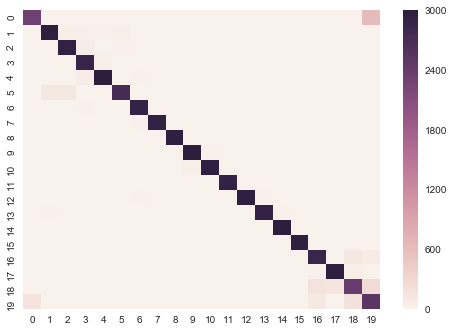

In [18]:
sns.heatmap(cm)

As seen above, the classes such as 16, 18 and 19 have aggregated with more confusions. Topics 16, 18, 19 are talk.politics.guns, talk.politics.misc, talk.religion.misc, which inherently relate to similar subject. There is also a heat spot between topic 0 (alt.atheism) and topic 19 (talk.religion.misc) due to their similarity in the context as well.

## Q2

### (a)

In [19]:
def featureSizeAC(data, clf, num_run, **params):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        train_mean_fs: list.
        train_ci_fs: list.
        test_mean_fs: list.
        test_ci_fs: list.
        
    """
    feature_precentage = np.linspace(0.1, 1, 10, endpoint=True)
    
    ########### your code goes here ###########
    
    N_fp = len(feature_precentage)
    train_mean_fs = N_fp * [None]
    test_mean_fs = N_fp * [None]
    train_ci_fs = N_fp * [None]
    test_ci_fs = N_fp * [None]
    
    # Total feature size
    M = len(data.columns) - 2
    
    if clf == 'LR':
        clf = LogisticRegression(C=params['c'])
    elif clf == 'SVM':
        clf = SVC(C=params['c'])
    elif clf == 'NB':
        clf = GaussianNB()
    
    features = data.iloc[:, :-2].as_matrix()
    target = data['target'].as_matrix()
    
    for j, fp in enumerate(feature_precentage):
        m = int(M * fp)
            
        train_scores = num_run * [None]
        test_scores = num_run * [None]
    
        for i in range(num_run):
            features_train, features_test, target_train, target_test = train_test_split(features[:, :m], target, test_size=0.3)
            clf_model = clf.fit(features_train, target_train)

            target_train_pred = clf_model.predict(features_train)
            train_scores[i] = accuracy_score(target_train, target_train_pred)

            target_test_pred = clf_model.predict(features_test)
            test_scores[i] = accuracy_score(target_test, target_test_pred)
        
        train_mean_fs[j] = np.mean(train_scores)
        test_mean_fs[j] = np.mean(test_scores)
        train_ci_fs[j] = mean_confidence_interval(train_scores)[1]
        test_ci_fs[j] = mean_confidence_interval(test_scores)[1]

    ###########         end         ###########
    return train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs

In [20]:
train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs = featureSizeAC(data, 'LR', 5, c=0.01)

### (b)

In [21]:
def featureSizePlot(feature_size, train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve = plt.errorbar(feature_size, test_mean_fs, color=sns.xkcd_rgb["pale red"], yerr=test_ci_fs)
    train_curve = plt.errorbar(feature_size, train_mean_fs, color=sns.xkcd_rgb["denim blue"], yerr=train_ci_fs)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Feature Percentage')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Feature Size")
    plt.show()

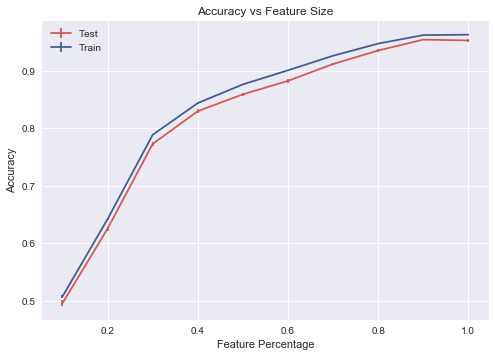

In [22]:
featureSizePlot(np.linspace(0.1, 1, 10, endpoint=True), train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs)

In the overall 400 features, it is found the higher in the feature size, the better performance.

## Q3

In [23]:
def hyperParameterAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
    
    OUTPUT
        test_mean_hp: list.  mean accuracy list of test
        test_ci_hp: list. confidence interval list of test
        train_mean_hp: list. mean accuracy list of train
        train_ci_hp: list. confidence interval list of train
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    params = np.logspace(-4, 4, num=9)
    
    ########### your code goes here ###########
    
    N_hp = len(params)
    train_mean_hp = N_hp * [None]
    test_mean_hp = N_hp * [None]
    train_ci_hp = N_hp * [None]
    test_ci_hp = N_hp * [None]

    for i, hp in enumerate(params):
        _, _, train_mean, test_mean, train_ci, test_ci = randomSplitCI(data, clf, num_run, c=hp)
        
        train_mean_hp[i] = train_mean
        test_mean_hp[i] = test_mean
        train_ci_hp[i] = train_ci
        test_ci_hp[i] = test_ci
    
    ###########         end         ###########
    return train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

In [24]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp = hyperParameterAC(data, 'LR', 3)

In [25]:
def hyperParameterPlot(params, train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve = plt.errorbar(params, test_mean_hp, color=sns.xkcd_rgb["pale red"], yerr=test_ci_hp)
    train_curve = plt.errorbar(params, train_mean_hp, color=sns.xkcd_rgb["denim blue"], yerr=train_ci_hp)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Parameter')
    plt.xscale("log")
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Parameters")
    plt.show()

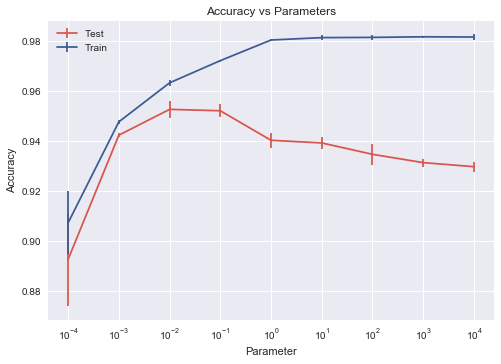

In [26]:
hyperParameterPlot(np.logspace(-4, 4, num=9), train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp )

The optimal hyperparameter is found to be 0.01 as seen above, because overfitting occurs as the hyperparameter increases.

## Q4

### (a)

In [27]:
def dataSizeAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        test_mean_ds: list.  mean accuracy list of test
        test_ci_ds: list. confidence interval list of test
        train_mean_ds: list. mean accuracy list of train
        train_ci_ds: list. confidence interval list of train
        
        
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    data_precentage = np.linspace(0.1, 1, 10, endpoint=True)
    
    ########### your code goes here ###########
    
    N_ds = len(data_precentage)
    train_mean_ds = N_ds * [None]
    test_mean_ds = N_ds * [None]
    train_ci_ds = N_ds * [None]
    test_ci_ds = N_ds * [None]
    
    if clf == 'LR':
        clf = LogisticRegression(C=0.01)
    elif clf == 'SVM':
        clf = SVC()
    elif clf == 'NB':
        clf = GaussianNB()
    
    features = data.iloc[:, :-2].as_matrix()
    target = data['target'].as_matrix()
    
    for j, ds in enumerate(data_precentage):
        
        train_scores = num_run * [None]
        test_scores = num_run * [None]
    
        for i in range(num_run):
            features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                        train_size=0.7 * ds, test_size=0.3)
            clf_model = clf.fit(features_train, target_train)

            target_train_pred = clf_model.predict(features_train)
            train_scores[i] = accuracy_score(target_train, target_train_pred)

            target_test_pred = clf_model.predict(features_test)
            test_scores[i] = accuracy_score(target_test, target_test_pred)
        
        train_mean_ds[j] = np.mean(train_scores)
        test_mean_ds[j] = np.mean(test_scores)
        train_ci_ds[j] = mean_confidence_interval(train_scores)[1]
        test_ci_ds[j] = mean_confidence_interval(test_scores)[1]

 
    ###########         end         ###########
    return train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds

In [28]:
train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds = dataSizeAC(data, 'LR', 3)

### (b)

In [29]:
def dataSizePlot(datasize, train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve = plt.errorbar(datasize, test_mean_ds, color=sns.xkcd_rgb["pale red"], yerr=test_ci_ds)
    train_curve = plt.errorbar(datasize, train_mean_ds, color=sns.xkcd_rgb["denim blue"], yerr=train_ci_ds)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Data Percentage')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Data Percentage")
    plt.show()

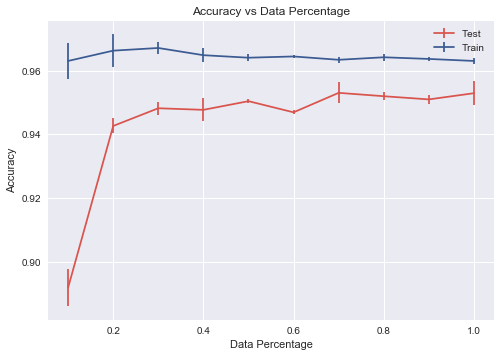

In [30]:
dataSizePlot(np.linspace(0.1, 1, 10, endpoint=True), train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds)

As seen, the higher data percentage of the training data being used the better the performance is.

## Q5

### (a)

### Data encoded by 'tf'

In [31]:
data_tf = dataPreprocessor(k=400, fs='tf', encode='tf', directorydf=directorydf, size=None)
data_tf.head(n=1)

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Initial Counter update complete...

processed 1 files
processed 5001 files
processed 10001 files
processed 15001 files
Encoding complete...



,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,open,mike,play,cause,local,toronto,copy,week,target,label
0,10,5,1,4,3,2,2,2,1,2,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\49960


### Data encoded by 'boolean'

In [32]:
data.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,open,mike,play,cause,local,toronto,copy,week,target,label
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\49960


### (b)

### Raw TF vs Binary TF

In [33]:
_, _, _, test_mean_tf, _, test_ci_tf = randomSplitCI(data_tf, 'LR', 10, c=0.01)
_, _, _, test_mean_bi, _, test_ci_bi = randomSplitCI(data, 'LR', 10, c=0.01)

print("Raw TF Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(test_mean_tf, [test_mean_tf - test_ci_tf, test_mean_tf + test_ci_tf])
     )
print("Binary TF Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(test_mean_bi, [test_mean_bi - test_ci_bi, test_mean_bi + test_ci_bi])
     )


Raw TF Test    
Average Accuracy: 0.9345166666666666     
Confidence Interval: [0.93358712361761886, 0.93544620971571424]
Binary TF Test    
Average Accuracy: 0.95235     
Confidence Interval: [0.95136423847597706, 0.953335761524023]


In [34]:
def compare_plot(mean_1, ci_1, mean_2, ci_2, leg=["A", "B"]):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    pt_1 = plt.errorbar([0], mean_1, color=sns.xkcd_rgb["pale red"], yerr=ci_1, fmt='o')
    pt_2 = plt.errorbar([0], mean_2, color=sns.xkcd_rgb["denim blue"], yerr=ci_2, fmt='o')
    plt.legend([pt_1, pt_2], leg)
#     plt.xlabel('')
    plt.ylabel('Accuracy')
    plt.title("Non-overlapping CI Accuracy Comparison")
    plt.show()

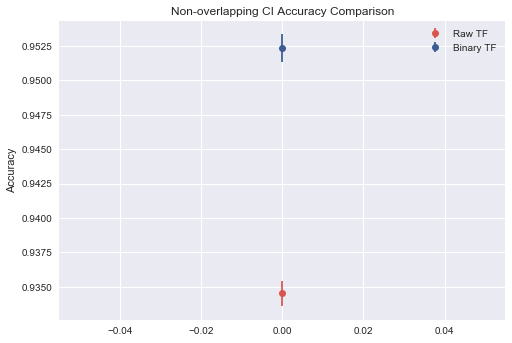

In [35]:
compare_plot(test_mean_tf, test_ci_tf, test_mean_bi, test_ci_bi, leg=["Raw TF", "Binary TF"])

As seen above, the data encoded with binary term frequncy performs slightly better, which is due to the fact that binary encoding method forces the features to be normalized to a same scale (i.e. 0 or 1), more friendly for the classifier.

## Q6

### (a)

### NB vs LR

In [36]:
_, _, _, test_mean_nb, _, test_ci_nb = randomSplitCI(data, 'NB', 10, c=0.01)
_, _, _, test_mean_lr, _, test_ci_lr = randomSplitCI(data, 'LR', 10, c=0.01)

print("NB Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(test_mean_nb, [test_mean_nb - test_ci_nb, test_mean_nb + test_ci_nb])
     )
print("LR Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(test_mean_lr, [test_mean_lr - test_ci_lr, test_mean_lr + test_ci_lr])
     )

NB Test    
Average Accuracy: 0.9258166666666666     
Confidence Interval: [0.92048119067807144, 0.93115214265526181]
LR Test    
Average Accuracy: 0.9521833333333334     
Confidence Interval: [0.95077004618415972, 0.95359662048250704]


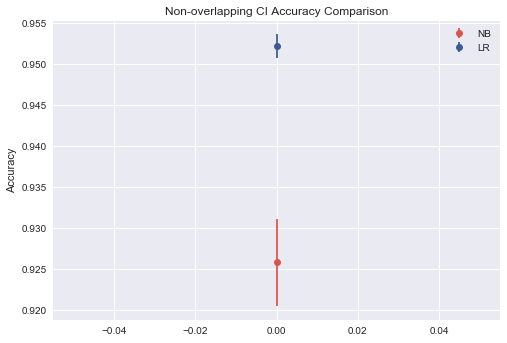

In [37]:
compare_plot(test_mean_nb, test_ci_nb, test_mean_lr, test_ci_lr, leg=["NB", "LR"])

The NB places a strong assumption of conditionally independence between the features, which in reality does not hold but close, indicating NB has a higher bias or lower variance compared to LR.

# Binary LR Classification for "sci.space"

## Q1

### (a)

i) For features preparation, we use a binary term frequency-based unigram model to encode the text documents. I think the unigram term frequency encoding method is a reasonable first step to start with, which is straightforward to implement. The binary encoding method allows the features to be normalized to the same scale (0 or 1), which is highly desirable for some classifier, such as SVM and NB.

In the preprocessing part, we firstly use lowercase unification to avoid case-sensitivity. Secondly, the stop words are removed in the text. It is observed there are plenty of 2-letter word tokens that does not make much sense, possibly due to the lowercase of acronyms, which are removed as well. Finaly, a lemmatizer is applied in order to merge the similar words together.

ii) Feature ranking is based on the frequency of all the words updated from the entire document collection, the higher term frequency of a word, the higher ranking, which suggests potentially higher relevance in the context.

iii) The number of features selected directly affects the performance of a classification. Here it should be sufficiently large for the model in order to capture the essence, and computional-wise less expensive. Here, we use the top 400 words for the features.

### (b)

In [38]:
new_data = data.copy()
new_data['target'] = label_binarize(new_data['target'], classes=[14])

In [39]:
new_data.head()

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,open,mike,play,cause,local,toronto,copy,week,target,label
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\49960
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,0,0,1,0,0,20_newsgroups\alt.atheism\51060
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51119
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,20_newsgroups\alt.atheism\51120
4,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51121


### (c)

In [40]:
new_train_scores, new_test_scores, new_train_mean, new_test_mean, new_train_ci, new_test_ci = randomSplitCI(new_data, 'LR', 10, c=1.0)
print("Train\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(new_train_scores, new_train_mean, new_train_ci)
     )
print("Test\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(new_test_scores, new_test_mean, new_test_ci)
     )

Train    
Result of trails:[0.99985711223833673, 0.99992855611916842, 0.99978566835750515, 0.99978566835750515, 0.99992855611916842, 0.99985711223833673, 0.99985711223833673, 0.99971422447667357, 0.99985711223833673, 0.99985711223833673]     
Average Accuracy: 0.9998428234621703     
Confidence Interval: 3.5697724481094203e-05

Test    
Result of trails:[0.9986666666666667, 0.99850000000000005, 0.99883333333333335, 0.99883333333333335, 0.99783333333333335, 0.99833333333333329, 0.999, 0.99950000000000006, 0.9986666666666667, 0.99833333333333329]     
Average Accuracy: 0.9986499999999999     
Confidence Interval: 0.00024335473329321685


### (d)

Yes. In only a single trial, it does not take advantage of using the entire datasets because the data used for the testing is not contributed to your model training. With multiple randomized trials, you potentially use different training data in each trial from all the samples thus you will be able to see a general performance of the classifier in terms of the average accuracy and the confidence interval. The more trials we run, the smaller CI suggesting the average accuracy is closer to the true accuracy.

## Q2

### (a)

In [41]:
new_train_mean_fs, new_train_ci_fs, new_test_mean_fs, new_test_ci_fs = featureSizeAC(new_data, 'LR', 5, c=1.0)

### (b)

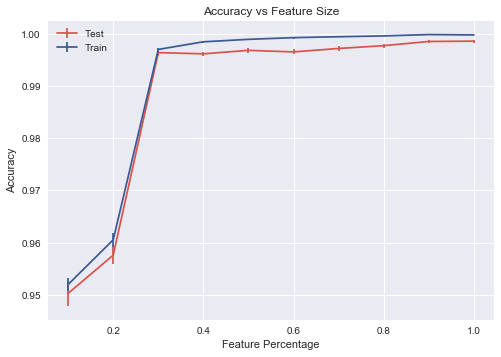

In [42]:
featureSizePlot(np.linspace(0.1, 1, 10, endpoint=True), new_train_mean_fs, new_train_ci_fs, new_test_mean_fs, new_test_ci_fs)

In the overall 400 features, as the feature size increases the performance is getting better.

## Q3

In [43]:
new_train_mean_hp, new_train_ci_hp, new_test_mean_hp, new_test_ci_hp = hyperParameterAC(new_data, 'LR', 3)

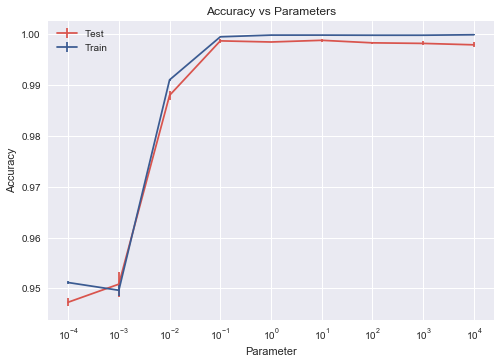

In [44]:
hyperParameterPlot(np.logspace(-4, 4, num=9), new_train_mean_hp, new_train_ci_hp, new_test_mean_hp, new_test_ci_hp)

The optimal hyperparameter is found to be 1.0 as seen above, because slight overfitting occurs as the hyperparameter increases.

## Q4

### (a)

In [45]:
new_train_mean_ds, new_train_ci_ds, new_test_mean_ds, new_test_ci_ds = dataSizeAC(new_data, 'LR', 3)

### (b)

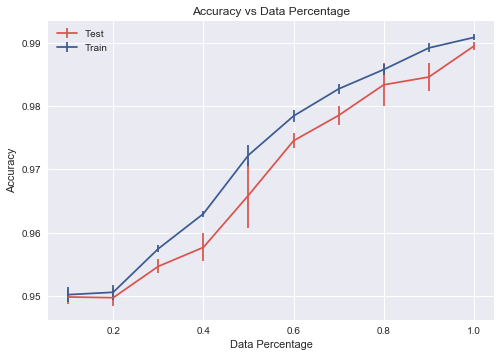

In [46]:
dataSizePlot(np.linspace(0.1, 1, 10, endpoint=True), new_train_mean_ds, new_train_ci_ds, new_test_mean_ds, new_test_ci_ds)

As seen, the higher data percentage of the training data being used the better the performance is.

## Q5

### (a)

### Data encoded by 'tf'

In [47]:
new_data_tf = data_tf.copy()
new_data_tf['target'] = label_binarize(new_data_tf['target'], classes=[14])
new_data_tf.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,open,mike,play,cause,local,toronto,copy,week,target,label
0,10,5,1,4,3,2,2,2,1,2,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\49960


### Data encoded by 'boolean'

In [48]:
new_data.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,open,mike,play,cause,local,toronto,copy,week,target,label
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\49960


### (b)

### Raw TF vs Binary TF

In [49]:
_, _, _, new_test_mean_tf, _, new_test_ci_tf = randomSplitCI(new_data_tf, 'LR', 10, c=1.0)
_, _, _, new_test_mean_bi, _, new_test_ci_bi = randomSplitCI(new_data, 'LR', 10, c=1.0)

print("Raw TF Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(new_test_mean_tf, [new_test_mean_tf - new_test_ci_tf, new_test_mean_tf + new_test_ci_tf])
     )
print("Binary TF Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(new_test_mean_bi, [new_test_mean_bi - new_test_ci_bi, new_test_mean_bi + new_test_ci_bi])
     )


Raw TF Test    
Average Accuracy: 0.9972333333333335     
Confidence Interval: [0.9966727385904256, 0.99779392807624145]
Binary TF Test    
Average Accuracy: 0.9985666666666667     
Confidence Interval: [0.99832804507171746, 0.99880528826161596]


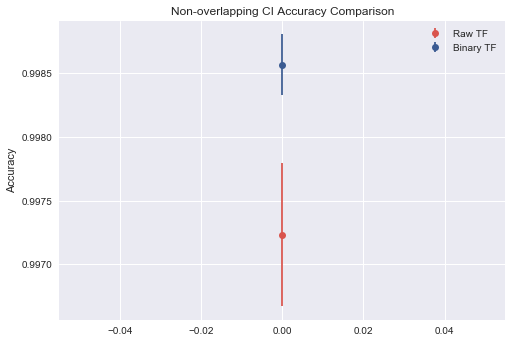

In [50]:
compare_plot(new_test_mean_tf, new_test_ci_tf, new_test_mean_bi, new_test_ci_bi, leg=["Raw TF", "Binary TF"])

As seen above, the data encoded with binary term frequncy performs slightly better, which is due to the fact that binary encoding method forces the features to be normalized to a same scale (i.e. 0 or 1), more friendly for the classifier.

## Q6

### (a)

### NB vs LR

In [51]:
_, _, _, new_test_mean_nb, _, new_test_ci_nb = randomSplitCI(new_data, 'NB', 10, c=1.0)
_, _, _, new_test_mean_lr, _, new_test_ci_lr = randomSplitCI(new_data, 'LR', 10, c=1.0)

print("NB Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(new_test_mean_nb, [new_test_mean_nb - new_test_ci_nb, new_test_mean_nb + new_test_ci_nb])
     )
print("LR Test\
    \nAverage Accuracy: {0} \
    \nConfidence Interval: {1}".format(new_test_mean_lr, [new_test_mean_lr - new_test_ci_lr, new_test_mean_lr + new_test_ci_lr])
     )

NB Test    
Average Accuracy: 0.9972166666666666     
Confidence Interval: [0.99686947534733206, 0.99756385798600122]
LR Test    
Average Accuracy: 0.9988833333333332     
Confidence Interval: [0.99864915069993088, 0.99911751596673559]


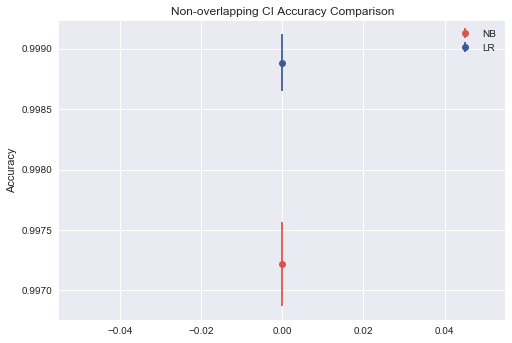

In [52]:
compare_plot(new_test_mean_nb, new_test_ci_nb, new_test_mean_lr, new_test_ci_lr, leg=["NB", "LR"])

The NB places a strong assumption of conditionally independence between the features, which in reality does not hold but close, indicating NB has a higher bias or lower variance compared to LR.

# Validation

### dataPreprocessor

In [53]:
assert(isinstance(data, pd.DataFrame)), "data should be pandas dataframe type"

### randomSplitCI

In [54]:
assert(isinstance(train_scores, list)), "train_scores should be list type"
assert(isinstance(test_scores, list)), "test_scores should be list type"
assert(isinstance(train_mean, float)), "train_mean should be float type"
assert(isinstance(test_mean, float)), "test_mean should be float type"
assert(isinstance(train_ci, float)), "train_ci should be float type"
assert(isinstance(test_ci, float)), "test_ci should be float type"

### randomSplitCM

In [55]:
assert(isinstance(cm, pd.DataFrame)), "Confusion matrix should be pandas dataframe type"

### featureSizeAC

In [56]:
assert(isinstance(train_mean_fs, list)), "train_mean_fs should be list type"
assert(isinstance(test_mean_fs, list)), "test_mean_fs should be list type"
assert(isinstance(train_ci_fs, list)), "train_ci_fs should be list type"
assert(isinstance(test_ci_fs, list)), "test_ci_fs should be list type"
assert(len(train_mean_fs)==len(train_ci_fs)), \
"list length of mean and confidence interval are not equal(train)"
assert(len(test_mean_fs)==len(test_ci_fs)), \
"list length of mean and confidence interval are not equal(test)"

### hyperParameterAC

In [57]:
assert(isinstance(train_mean_hp, list)), "train_mean_hp should be list type"
assert(isinstance(test_mean_hp, list)), "test_mean_hp should be list type"
assert(isinstance(train_ci_hp, list)), "train_ci_hp should be list type"
assert(isinstance(test_ci_hp, list)), "test_ci_hp should be list type"
assert(len(train_mean_hp)==len(train_ci_hp)), \
"list length of mean and confidence interval are not equal(train)"
assert(len(test_mean_hp)==len(test_ci_hp)), \
"list length of mean and confidence interval are not equal(test)"

### dataSizeAC

In [58]:
train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds
assert(isinstance(train_mean_ds, list)), "train_mean_ds should be list type"
assert(isinstance(test_mean_ds, list)), "test_mean_ds should be list type"
assert(isinstance(train_ci_ds, list)), "train_ci_ds should be list type"
assert(isinstance(test_ci_ds, list)), "test_ci_ds should be list type"
assert(len(train_mean_ds)==len(train_ci_ds)), \
"list length of mean and confidence interval are not equal(train)"
assert(len(test_mean_ds)==len(test_ci_ds)), \
"list length of mean and confidence interval are not equal(test)"